In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import operator
from utils import *

modified 0207

In [2]:
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/'

# exercise 837, topic 41, area 9
exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
relation = pd.read_csv(bath_path+'relationship_annotation_training.csv', encoding = "utf-8",low_memory=False)
log = pd.read_csv(bath_path+'junyi_ProblemLog_original.csv', encoding = "utf-8",low_memory=False)

In [3]:
log.head()

,user_id,exercise,problem_type,problem_number,topic_mode,suggested,review_mode,time_done,time_taken,time_taken_attempts,correct,count_attempts,hint_used,count_hints,hint_time_taken_list,earned_proficiency,points_earned
0,12884,time_terminology,analog_word,1,False,False,False,1420714810324490,4,3&1,False,2,False,0,NaN,False,0
1,239464,multiplication_1,0,6,False,False,False,1403098400836660,2,2,True,1,False,0,NaN,False,14
2,147359,adding_decimals_0.5,0,6,False,False,False,1418890695540340,16,16,True,1,False,0,NaN,False,75
3,158155,multiplication_1,0,3,False,False,False,1400469444264040,2,2,True,1,False,0,NaN,False,75
4,147151,subtraction_2,subtraction-2,10,True,True,False,1382650905730160,4,4,True,1,False,0,NaN,False,225


In [4]:
exercise.head()

,name,live,prerequisites,h_position,v_position,creation_date,seconds_per_fast_problem,pretty_display_name,short_display_name,topic,area
0,parabola_intuition_1,True,recognizing_conic_sections,47,2,2012-10-11 17:55:24.8056 UTC,13.0,?物線直覺 1,?物線直覺1,conic-sections,algebra
1,circles_and_arcs,True,NaN,40,-20,2012-10-11 17:55:33.41014 UTC,27.0,圓與弧,圓與弧,area-perimeter-and-volume,geometry
2,inscribed_angles_3,True,inscribed_angles_2,44,-22,2012-10-11 17:55:44.11836 UTC,5.0,圓周角與圓心角換算 3,圓周角與圓心角換算3,circle-properties,geometry
3,solving_quadratics_by_factoring,True,factoring_polynomials_1,50,-2,2012-10-11 17:54:59.28029 UTC,7.0,因式分解法,因式分解法,quadtratics,algebra
4,graphing_parabolas_1,True,graphing_parabolas_0.5,52,0,2012-10-11 17:55:00.48268 UTC,24.0,畫拋物線 1,畫拋物線1,quadtratics,algebra


# find ground-truth knowledge graph

In [5]:
# exercise-id re-match
num_ex = len(exercise)

ex_new_id = pd.DataFrame(columns=['exercise_name', 'exercise_id', 'prerequisite_name', 'prerequisite_id'])
ex_new_id['exercise_name'] = exercise.name
ex_new_id['exercise_id'] = np.arange(len(exercise))
ex_new_id['prerequisite_name'] = exercise.prerequisites

for i in range(len(ex_new_id.prerequisite_name)):
    pre = ex_new_id['prerequisite_name'][i]
    ind = exercise.loc[exercise.name == pre].index
    if len(ind) == 0:
        ex_new_id.prerequisite_id[i] = np.nan
    else:
        ex_new_id.prerequisite_id[i] = ind[0]

In [6]:
ex_new_id.head()

,exercise_name,exercise_id,prerequisite_name,prerequisite_id
0,parabola_intuition_1,0,recognizing_conic_sections,524
1,circles_and_arcs,1,NaN,NaN
2,inscribed_angles_3,2,inscribed_angles_2,331
3,solving_quadratics_by_factoring,3,factoring_polynomials_1,673
4,graphing_parabolas_1,4,graphing_parabolas_0.5,330


In [7]:
check_nan(ex_new_id)

number of NaN in column exercise_name: 0
number of NaN in column exercise_id: 0
number of NaN in column prerequisite_name: 95
number of NaN in column prerequisite_id: 284


In [11]:
import networkx as nx
G = nx.DiGraph()

# create nodes for the graph, with label as the nodes' name
node_label = [(ex_new_id.exercise_id[i], dict(name=ex_new_id.exercise_name[i])) for i in range(len(ex_new_id))]
G.add_nodes_from(node_label)

# the edge of the graph; a->b means a is a prerequiste of b
edge = []
for i in range(len(ex_new_id)):
    if not pd.isna(ex_new_id.prerequisite_id[i]):
        edge.append((ex_new_id.prerequisite_id[i], ex_new_id.exercise_id[i]))
G.add_edges_from(edge)

# add position of each node on the graph
pos = dict()
for i in range(num_ex):
    pos.update({i: (exercise.h_position[i], exercise.v_position[i])})

# save adjacancy matrix to numpy file
adj = nx.adjacency_matrix(G).toarray()
path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/adj.npy'
np.save(path, adj)

AttributeError: 'DataFrame' object has no attribute 'name'

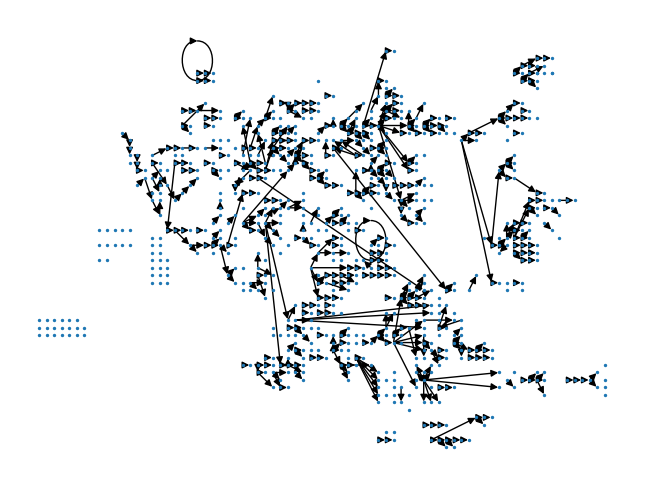

In [12]:
# visualize
nx.draw(G, with_labels=False, pos=pos, node_size=2)
nx.draw(G, labels=ex_new_id.name)

In [ ]:
# lets see if i can make it interactive

In [21]:
!pip install bokeh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.2 MB/s eta 0:00:00
  Using cached PyYAML-6.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (661 kB)


In [22]:
from bokeh.io import output_notebook, show, save
output_notebook()
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [26]:
#Choose a title!
title = 'Junyi Knowledge Graph'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

# statistics check

In [35]:
check_nan(log)
count_unique(log, ['user_id', 'exercise'])
print(len(log))

number of NaN in column user_id: 0
number of NaN in column exercise: 0
number of NaN in column problem_type: 0
number of NaN in column problem_number: 0
number of NaN in column topic_mode: 0
number of NaN in column suggested: 0
number of NaN in column review_mode: 0
number of NaN in column time_done: 0
number of NaN in column time_taken: 0
number of NaN in column time_taken_attempts: 62365
number of NaN in column correct: 0
number of NaN in column count_attempts: 0
number of NaN in column hint_used: 0
number of NaN in column count_hints: 0
number of NaN in column hint_time_taken_list: 24254263
number of NaN in column earned_proficiency: 0
number of NaN in column points_earned: 0
number of unique value in user_id: 247606
number of unique value in exercise: 722
25925992


In [37]:
remove_thres = 200
log = remove_log(log, 'user_id', num=remove_thres)
print(len(log))

20314363


In [ ]:
# 50: 23907121
# 60: 23590779

# pre-process

In [58]:
# create new data
df = pd.DataFrame(columns=['user_id', 'problem_id', 'skill_id', 'timestamp', 'dwell_time', 'correct'])
df.user_id = log.user_id
df.problem_id = log.exercise
df.skill_id = log.exercise
df.timestamp = log.time_done
df.dwell_time = log.time_taken
df.correct = log.correct * 1

In [59]:
df.head()

,user_id,problem_id,skill_id,timestamp,dwell_time,correct
0,12884,time_terminology,time_terminology,1420714810324490,4,0
4,147151,subtraction_2,subtraction_2,1382650905730160,4,1
6,126493,telling_time_2,telling_time_2,1395367016571340,19,0
8,91712,representing_numbers,representing_numbers,1395808884278610,4,1
9,13719,multiplication_1,multiplication_1,1394098238458960,2,1


In [60]:
df = df.sort_values('timestamp', ascending=True)

In [61]:
df.head()

,user_id,problem_id,skill_id,timestamp,dwell_time,correct
16566284,101006,area_of_a_circle,area_of_a_circle,1350023005827490,15,1
5363433,109333,solid_geometry,solid_geometry,1350037552915380,37,1
24911409,109333,solid_geometry,solid_geometry,1350037566856140,6,1
16321743,109333,solid_geometry,solid_geometry,1350037575120770,29,0
4570457,109333,solid_geometry,solid_geometry,1350037604733250,14,0


In [62]:
# re-index
# - skill
df['skill_name'] = df['skill_id']
skill_dict = dict(zip(ex_new_id.exercise_name, ex_new_id.exercise_id))
df['skill_id'] = df['skill_id'].apply(lambda x: skill_dict[x])
# - problem
df['problem_id'] = df['skill_id']
# - student
stu_id = list(df['user_id'].unique())
stu_dict = dict(zip(stu_id, range(len(stu_id))))
df['user_id'] = df['user_id'].apply(lambda x: stu_dict[x])

In [64]:
df = df.astype({
    'timestamp': np.float64,
    'dwell_time': np.float64,
    'correct': np.float64,
    'problem_id': np.int64,
    'skill_id': np.int64
    })

In [65]:
# Save
df.to_csv(bath_path+'interactions_{}.csv'.format(remove_thres), sep='\t', index=False)

In [66]:
count_unique(df, list(df.columns))
len(df)

number of unique value in user_id: 26629
number of unique value in problem_id: 721
number of unique value in skill_id: 721
number of unique value in timestamp: 20312955
number of unique value in dwell_time: 6634
number of unique value in correct: 2
number of unique value in skill_name: 721


20314363